To prepare the required environment using conda/mamba, run the following commands:

```bash
# create the environment
mamba create -n autokeras python=3.10
mamba activate autokeras

# install conda requirements
mamba install python xarray dask netCDF4 bottleneck scikit-learn tqdm seaborn matplotlib

# install pip requirements
pip install nilearn autokeras -U
```

In [1]:
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import clear_output
from python.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from tqdm import tqdm


In [27]:
# PARAMETERS

TMP_DIR = 'tmp/autokeras'

ATLAS = 'dosenbach2010'
KIND = 'partial correlation'
AGGREGATE_NETWORKS=True

In [28]:
# 0. DATA


subjects = ConnectivityPipeline().transform(None).coords['subject'].values
groups = np.array([s[:4] for s in subjects])

X = subjects.reshape(-1, 1)
y = groups

from sklearn.preprocessing import LabelEncoder
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)


prep_pipe  = Pipeline([
    ('connectivity', ConnectivityPipeline(ATLAS, KIND, AGGREGATE_NETWORKS)),
    ('vectorize', ConnectivityVectorizer()),
])

X = prep_pipe.fit_transform(X, y)
feature_names: np.ndarray = prep_pipe.get_feature_names_out()

In [ ]:
# 1. MODEL

cv = StratifiedShuffleSplit(n_splits=20, test_size=8)

val_scores = []
chance_scores = []

chance_model = DummyClassifier(strategy='stratified')

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits(X, y)):

    project_name = f'{TMP_DIR}/{ATLAS}_{KIND}_{np.random.randint(10000)}'

    auto_model = ak.AutoModel(
        inputs=ak.StructuredDataInput(
            column_names=feature_names.tolist(),
            column_types={feat: 'numerical' for feat in feature_names},
            name=f'{ATLAS}_{KIND}'),
        outputs=ak.ClassificationHead(metrics=['accuracy'],
                                      loss=tf.keras.losses.BinaryCrossentropy()),
        project_name=project_name,
        tuner='bayesian',
        overwrite=True,
        max_trials=5,
        objective='val_accuracy'
    )

    history = auto_model.fit(
        X[train], y[train],
        # validation_data=(X[test], y[test]),
        callbacks=[
            tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True)],
        epochs=100,
        batch_size=8,
        verbose=0)

    # y_pred = auto_model.predict(X[test])
    # score = accuracy_score(y[test], y_pred)
    loss, val_score = auto_model.evaluate(X[test], y[test], batch_size=8)
    val_scores.append(val_score)

    chance_score = chance_model.fit(X[train], y[train]).score(X[test], y[test])
    chance_scores.append(chance_score)

    clear_output()
    print(f'val_score, chance_score: {val_score}, {chance_score}')

clear_output()

print('val_scores:', val_scores)

cross-validated val_accuracy: 0.6625
cross-validated chance_accuracy: 0.54375


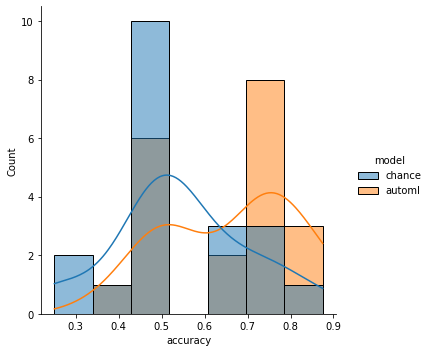

In [25]:
# REPORT

scores = pd.DataFrame({
    'chance': chance_scores,
    'automl': val_scores
}).melt(var_name='model', value_name='accuracy')

print('cross-validated val_accuracy:', np.mean(val_scores))
print('cross-validated chance_accuracy:', np.mean(chance_scores))

sns.displot(data=scores, hue='model', x='accuracy', kde=True)

plt.show()

In [6]:
#  DEBUG
print('one of the fitted model:', auto_model.export_model().summary())

cross-validated val_accuracy: 0.6625
cross-validated chance_accuracy: 0.54375
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 21)               0         
 ltiCategoryEncoding)                                            
                                                                 
 dense (Dense)               (None, 256)               5632      
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 re_lu_1 (ReLU)              (None, 16)          